In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit.aqua import QuantumInstance
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import pylab
from qiskit.aqua import aqua_globals
from qiskit.providers.aer.noise.device.parameters import gate_error_values
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.chemistry.drivers import PySCFDriver, UnitsType, Molecule
from qiskit.chemistry.transformations import FermionicTransformation, FermionicQubitMappingType
from qiskit.chemistry.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms import VQE
from qiskit.circuit.library import TwoLocal
import numpy as np

In [2]:
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
#print(provider.backends()) # available backends
backend = Aer.get_backend("qasm_simulator")
print(backend)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


qasm_simulator


In [3]:
#Set the seed for reproducible results
aqua_globals.random_seed = 100
seed_simulator = 100
seed_transpiler=100
np.random.seed(100)

In [4]:
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
transformation = FermionicTransformation(qubit_mapping=FermionicQubitMappingType.JORDAN_WIGNER)

numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(transformation, numpy_solver)
res = calc.solve(driver)
energy = -1.137306035753
print (energy)
print (res)

-1.137306035753
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
  - frozen energy part: 0.0
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
    - frozen energy part: [0.0  0.0  0.0]
    - particle hole part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.0]  Total: 0.
 


In [5]:
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [6]:
# Noise models
models = ['ibmqx2', 'ibmq_16_melbourne', 'ibmq_vigo', 'ibmq_ourense', 'ibmq_valencia', 'ibmq_armonk', 'ibmq_athens', 'ibmq_santiago']


var_forms = [('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)]),
             ('RY_CZ', 'ry', 'cz', [(2, 3), (1, 2), (0, 1), (0, 3)]),
             ('RYRZ_CX', ['ry', 'rz'], 'cx', 'full'),
             ('RYRZ_CZ', ['ry', 'rz'], 'cz','full'),
             ('HRX_CX', ['h', 'rx'], 'cx', 'full'),
             ('HRX_CZ', ['h', 'rx'], 'cz', 'full')]

energies = np.empty([len(var_forms), len(models)])
print(energies.shape)

for i, j in enumerate(models):
    for k in range(len(var_forms)):
        print(var_forms[k])
        print(models[i])
        device = provider.get_backend(models[i])
        properties = device.properties()   
        gate_error = gate_error_values(properties)
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates
        print(noise_model)
        print(gate_error)

        quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler,
                                   coupling_map=coupling_map,basis_gates=basis_gates, noise_model=noise_model)
        
        num_qubits = 4
        optimizer = SPSA(maxiter=200)
        tl_circuit = TwoLocal(num_qubits, var_forms[k][1], var_forms[k][2], reps=1, entanglement=var_forms[k][3], insert_barriers=True)
        vqe_solver = VQE(var_form = tl_circuit, quantum_instance = quantum_instance, optimizer= optimizer, callback=store_intermediate_result) 
        calc = GroundStateEigensolver(transformation, vqe_solver)
        result = calc.solve(driver)
        energies[k][i] = result.groundenergy + 0.719968994449
        print(energies[k][i])
        
print('Energies:', energies)

(6, 8)
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
ibmqx2
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 2]), ('cx', [2, 4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 2]), ('cx', [2, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 2]), ('cx', [2, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
[('id', [0], 0.0016534221880700306), ('id', [1], 0.0011798602585342006), ('id', [2], 0.0012809491208743825), ('id', [3], 0.0006296682355227786), ('id', [4], 0.0005555221869356988), ('rz', [0], 0), ('rz', [1], 0), ('rz', [2], 0), ('rz', [3], 0), ('rz', [4], 0), ('sx', [0], 0.0

-0.8528939375636007
('HRX_CZ', ['h', 'rx'], 'cz', 'full')
ibmqx2
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 2]), ('cx', [2, 4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 2]), ('cx', [2, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 2]), ('cx', [2, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
[('id', [0], 0.0016534221880700306), ('id', [1], 0.0011798602585342006), ('id', [2], 0.0012809491208743825), ('id', [3], 0.0006296682355227786), ('id', [4], 0.0005555221869356988), ('rz', [0], 0), ('rz', [1], 0), ('rz', [2], 0), ('rz', [3], 0), ('rz', [4], 0), ('sx', [0], 0.001653

-0.7772247331367332
('RYRZ_CX', ['ry', 'rz'], 'cx', 'full')
ibmq_16_melbourne
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('id', [7]), ('id', [8]), ('id', [9]), ('id', [10]), ('id', [11]), ('id', [12]), ('id', [13]), ('id', [14]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('sx', [5]), ('sx', [6]), ('sx', [7]), ('sx', [8]), ('sx', [9]), ('sx', [10]), ('sx', [11]), ('sx', [12]), ('sx', [13]), ('sx', [14]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('x', [5]), ('x', [6]), ('x', [7]), ('x', [8]), ('x', [9]), ('x', [10]), ('x', [11]), ('x', [12]), ('x', [13]), ('x', [14]), ('cx', [14, 0]), ('cx', [0, 14]), ('cx', [14, 13]), ('cx', [13, 14]), ('cx', [6, 8]), ('cx', [8, 6]), ('cx', [5, 9]), ('

-0.5186319331358515
('HRX_CX', ['h', 'rx'], 'cx', 'full')
ibmq_16_melbourne
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('id', [7]), ('id', [8]), ('id', [9]), ('id', [10]), ('id', [11]), ('id', [12]), ('id', [13]), ('id', [14]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('sx', [5]), ('sx', [6]), ('sx', [7]), ('sx', [8]), ('sx', [9]), ('sx', [10]), ('sx', [11]), ('sx', [12]), ('sx', [13]), ('sx', [14]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('x', [5]), ('x', [6]), ('x', [7]), ('x', [8]), ('x', [9]), ('x', [10]), ('x', [11]), ('x', [12]), ('x', [13]), ('x', [14]), ('cx', [14, 0]), ('cx', [0, 14]), ('cx', [14, 13]), ('cx', [13, 14]), ('cx', [6, 8]), ('cx', [8, 6]), ('cx', [5, 9]), ('cx

-0.1374860681453327
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
ibmq_vigo
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
[('id', [0], 0.0003185887740033112), ('id', [1], 0.0004906973004148923), ('id', [2], 0.0005720080158301161), ('id', [3], 0.0005067390412669303), ('id', [4], 0.0006937339016727027), ('rz', [0], 0), ('rz', [1], 0), ('rz', [2], 0), ('rz', [3], 0), ('rz', [4], 0), ('sx', [0], 0.0003185887740033112), ('sx', [1], 0.0004906973004

-0.4071643451260809
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
ibmq_ourense
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 3]), ('cx', [3, 4]), ('cx', [3, 1]), ('cx', [1, 3]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [1, 0]), ('cx', [0, 1]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
[('id', [0], 0.00033879002527439944), ('id', [1], 0.00029076812563739486), ('id', [2], 0.00028037450637294673), ('id', [3], 0.00039562055518803423), ('id', [4], 0.000436245971543454), ('rz', [0], 0), ('rz', [1], 0), ('rz', [2], 0), ('rz', [3], 0), ('rz', [4], 0), ('sx', [0], 0.00033879002527439944), ('sx', [1], 0.000290

-0.28100722424292024
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
ibmq_valencia
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [3, 4]), ('cx', [4, 3]), ('cx', [1, 3]), ('cx', [3, 1]), ('cx', [2, 1]), ('cx', [1, 2]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
[('id', [0], 0.0003794424471326283), ('id', [1], 0.0003776909177694257), ('id', [2], 0.0004734162843976337), ('id', [3], 0.0003435988021675106), ('id', [4], 0.0002922423846436214), ('rz', [0], 0), ('rz', [1], 0), ('rz', [2], 0), ('rz', [3], 0), ('rz', [4], 0), ('sx', [0], 0.0003794424471326283), ('sx', [1], 0.00037769

-0.24278316082307339
('RY_CX', 'ry', 'cx', [(2, 3), (1, 2), (0, 1), (0, 3)])
ibmq_armonk
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'sx', 'measure', 'x']
  Qubits with noise: [0]
  Specific qubit errors: [('id', [0]), ('sx', [0]), ('x', [0]), ('measure', [0])]
[('id', [0], 0.0003717065233846608), ('rz', [0], 0), ('sx', [0], 0.0003717065233846608), ('x', [0], 0.0003717065233846608)]
-1.0707326862274658
('RY_CZ', 'ry', 'cz', [(2, 3), (1, 2), (0, 1), (0, 3)])
ibmq_armonk
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'sx', 'measure', 'x']
  Qubits with noise: [0]
  Specific qubit errors: [('id', [0]), ('sx', [0]), ('x', [0]), ('measure', [0])]
[('id', [0], 0.0003717065233846608), ('rz', [0], 0), ('sx', [0], 0.0003717065233846608), ('x', [0], 0.0003717065233846608)]
-1.0698492331035194
('RYRZ_CX', ['ry', 'rz'], 'cx', 'full')
ibmq_armonk
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Inst

-0.991871677688593
('HRX_CX', ['h', 'rx'], 'cx', 'full')
ibmq_athens
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 3]), ('cx', [3, 4]), ('cx', [2, 3]), ('cx', [3, 2]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [1, 0]), ('cx', [0, 1]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
[('id', [0], 0.00030550492962461124), ('id', [1], 0.0003025536937473449), ('id', [2], 0.00021908248675413475), ('id', [3], 0.00046959658442356176), ('id', [4], 0.000276385885038949), ('rz', [0], 0), ('rz', [1], 0), ('rz', [2], 0), ('rz', [3], 0), ('rz', [4], 0), ('sx', [0], 0.00030550492962461124), ('sx', [1], 0.0003025536937473449), ('sx'

-1.015002567767759
('HRX_CX', ['h', 'rx'], 'cx', 'full')
ibmq_santiago
NoiseModel:
  Basis gates: ['cx', 'id', 'sx', 'u3', 'x']
  Instructions with noise: ['id', 'x', 'measure', 'sx', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('sx', [0]), ('sx', [1]), ('sx', [2]), ('sx', [3]), ('sx', [4]), ('x', [0]), ('x', [1]), ('x', [2]), ('x', [3]), ('x', [4]), ('cx', [4, 3]), ('cx', [3, 4]), ('cx', [2, 3]), ('cx', [3, 2]), ('cx', [2, 1]), ('cx', [1, 2]), ('cx', [0, 1]), ('cx', [1, 0]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]
[('id', [0], 0.00026605647093598105), ('id', [1], 0.00017398448667688748), ('id', [2], 0.00019022629751262575), ('id', [3], 0.00023231209255248104), ('id', [4], 0.0003565547861341684), ('rz', [0], 0), ('rz', [1], 0), ('rz', [2], 0), ('rz', [3], 0), ('rz', [4], 0), ('sx', [0], 0.00026605647093598105), ('sx', [1], 0.00017398448667688748), 

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

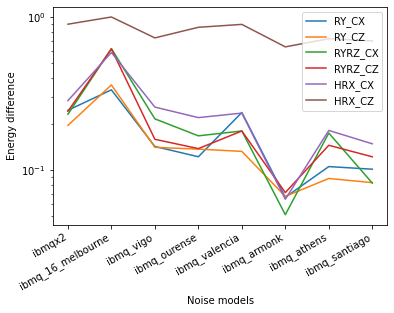

In [7]:
for k in range(len(var_forms)):
    pylab.plot(models, energies[k]-energy, label=var_forms[k][0])
pylab.xlabel('Noise models')
pylab.ylabel('Energy difference')
pylab.yscale('log')
#pylab.title('H2 Ground State Energy Difference from Reference')
pylab.legend(loc='upper right');
pylab.xticks(rotation=30, ha='right')